# NLE Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno=237707 #this MUST be updated to your candidate number so that you get a unique data sample


In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn import preprocessing
import statistics


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [3]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['the', 'summer', 'movie', 'season', 'is', 'always', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [5]:
# Splitting the training and testing data 
def split_my_data(data, ratio = 0.7):
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))   
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]  
    return train, test 

In [6]:
# Pre-processing function - Removes stop words and applies stemming

from nltk.stem.porter import PorterStemmer

stop = stopwords.words('english') 
st = PorterStemmer()

def pre_processing(words):
    stop_words = [i for i in words if i.isalpha() and i not in stop]
    stemm = [st.stem(token) for token in stop_words]
    return stemm


In [7]:
# Separating the positive and negative reviews
pos_review_ids = movie_reviews.fileids('pos')
neg_review_ids = movie_reviews.fileids('neg')

# Splitting the training and testing data 
pos_train_ids, pos_test_ids = split_my_data(pos_review_ids)
neg_train_ids, neg_test_ids = split_my_data(neg_review_ids)

# Merging the testing data
training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

training_norm=[(FreqDist(pre_processing(wordlist)),label) for (wordlist,label) in training]
testing_norm=[(FreqDist(pre_processing(wordlist)),label) for (wordlist,label) in testing]

In [8]:
# A list of frequency distribution with positive and negative reviews pre-processed 
def pre_processed_training(pos=pos_train_ids, neg=neg_train_ids):
  pos_review = [pre_processing(movie_reviews.words(word)) for word  in pos]
  neg_review = [pre_processing(movie_reviews.words(word)) for word  in neg]
  return pos_review, neg_review

In [9]:
# A list of frequency distribution of all words for positive and negative reviews
def freq_dist_words(pos, neg):
  pos_allFreqs = FreqDist()
  neg_allFreqs = FreqDist()

  for i in range(len(pos)):
    pos_allFreqs += FreqDist(pos[i])
    neg_allFreqs += FreqDist(neg[i])

  return pos_allFreqs, neg_allFreqs

In [10]:
# All words in the reviews put in a single list
def list_words(pos, neg): 
  pos_allWords = [word for word, freq in pos.items()]
  neg_allWords = [word for word, freq in neg.items()]
  return pos_allWords, neg_allWords

In [11]:
# A function that returns top k words that are unique to a sentiment 
def uniques(uniques, test, k):
  # Finding most common k for sentiment where we are searching for unique words from
  unique_freq = [word for word, _ in FreqDist(uniques).most_common(k)]
  # Finding most common k from the sentiment we are testing against
  test_freq = [word for word, _ in FreqDist(test).most_common(k)]
  # Creating a list of unique words 
  unique_list = [word for word in unique_freq if word not in test_freq]
  return unique_list

In [12]:
# A function that returns top k words that appear more frequently in one sentiment over another 
def word_ratio(pos, neg, ratio, k=2000):
  # Finding most common k frequenct distribution for each sentiment 
  pos = [i for i in pos.most_common(k)]
  neg = [i for i in neg.most_common(k)]

  # A list to hold words more common in one sentiment over another 
  P_words = []
  N_words = []

  # Looping through most common k in of positive and negative words 
  for P_word, P_freq in pos:
    for N_word, N_freq in neg:
      # checking if a word is more likely to be in a sentiment over another based on ratio set 
      if P_word == N_word and N_freq * ratio < P_freq:
        # Adding word to list if it appear more frequently 
        P_words.append(P_word)
      if P_word == N_word and P_freq * ratio < N_freq:
        N_words.append(N_word)
  
  return P_words, N_words

In [13]:
# Scores word based on occurance in the reviews 
def single_freq(word_list, corpus):
  myDict = {}
  # Creating dictionary for each word with default value of 0 
  for word in word_list:
    myDict[word] = 0
  # Looping thrugh keys in dictionary and words that have been derived (uniques and those with higher ratios)
  for key in myDict.keys():
    for words in corpus:
      if key in words:
        # Adding a score of 1 if the word appears atleast once in in each review 
        myDict[key] += 1

  return myDict

In [14]:
# Runs our experiment 
def get_wordList(pos, neg, k1, k2, ratio):
  # Finding the training data pre processed
  pos_review, neg_review = pre_processed_training(pos, neg)
  # Getting all the words from the corpus with their freuency distribution
  pos_allFreqs, neg_allFreqs = freq_dist_words(pos_review, neg_review)
  # Getting all the words from the frequency distribution in a list 
  pos_allWords, neg_allWords = list_words(pos_allFreqs, neg_allFreqs)

  # Finding words that are unique to a particular sentiment based on the top k most frequency distribution for each sentiment 
  unique_pos = uniques(pos_allFreqs, neg_allFreqs, k1)
  unique_neg = uniques(neg_allFreqs, pos_allFreqs, k1)
  print(f"Positive Uniques: {len(unique_pos)}\nNegative Uniques{len(unique_neg)}\n")

  # Finding words with r times higher ratio in one sentiment over another in top most frequent k for each sentiment 
  p_ratio, n_ratio = word_ratio(pos_allFreqs, neg_allFreqs, ratio, k=k2)
  print(f"Positive with {k2} times higher ratio: {len(p_ratio)}\nNegative  with {k2} times higher ratio: {len(n_ratio)}")

  # Combining unique words and higher ratios
  pos_candidates = unique_pos + p_ratio
  neg_candidates = unique_neg + n_ratio

  # Scoring words based on the number of reviews it occures in 
  pos_single = single_freq(pos_candidates, pos_review)
  neg_single = single_freq(neg_candidates, neg_review)

  # sorting data based on the highest rank
  pos_sorted_single = sorted(pos_single.items(), key=lambda x: x[1], reverse=True)
  neg_sorted_single = sorted(neg_single.items(), key=lambda x: x[1], reverse=True)

  # Creating of a list of words from our ranked data 
  positive_wordlist = [pos_sorted_single[i][0] for i in range(len(pos_sorted_single))]
  negative_wordlist = [neg_sorted_single[i][0] for i in range(len(neg_sorted_single))]
  
  # Return the list of words created 
  return positive_wordlist, negative_wordlist

**Question 1A**

In [15]:
# Running our program - deriving a ranked list of positive and negative words that can be used for the word list classifer 
unique_K = 1000
ratio_k = 3000
ratio = 2.5
positive_wordList, negative_wordList = get_wordList(pos_review_ids, neg_review_ids, unique_K, ratio_k, ratio)

Positive Uniques: 169
Negative Uniques169

Positive with 3000 times higher ratio: 62
Negative  with 3000 times higher ratio: 20


In [16]:
# Will return an output of 10 negative and 10 positive words 

k = 10 # Number of word in the word list 

print(f"===Positive Word List===\n{positive_wordList[:k]}\n")
print(f"===Negative Word List===\n{negative_wordList[:k]}")

===Positive Word List===
['portray', 'war', 'hilari', 'excel', 'color', 'solid', 'perfectli', 'brilliant', 'memor', 'equal']

===Negative Word List===
['bad', 'bore', 'suppos', 'wast', 'worst', 'stupid', 'ridicul', 'terribl', 'poor', 'aw']


**Experimentation and Analysis for Question 1B**

In [17]:
# Experimentations for different pre processing techniques

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def pre_processing_test(words, code):
  # If 0 normalise number 
  if code == 0:
    return ["NUM" if i.isdigit() else i for i in words]
  # If 1 remove stop words, numbers and punctuation 
  elif code == 1:
    return [i for i in words if i.isalpha() and i not in stop]
  # If 2 apply stemming
  elif code == 2:
    return [st.stem(token) for token in words]
  # Otherwise apply lemmatization
  else:
    return [lemmatizer.lemmatize(token) for token in words]


In [18]:
# Measuring reduction in average size of words for freq dist of each review 

def measure_pre_processing(training, code):
  # Getting lengths of frquency distribution before applying pre processing 
  actual_length = [len(FreqDist(data)) for data, _ in training]
  # Finding average number of words in the frequency distribution review in training data 
  actual_length = statistics.mean(actual_length)
  # Getting lengths of frquency distribution after applying pre processing 
  new_length = [len(FreqDist(pre_processing_test(data, code))) for data, _ in training]
  # Finding average number of words in the frequency distribution review in training data 
  new_length = statistics.mean(new_length)
  print(f"length reduced from {actual_length} to {new_length}\n Reduction Rate: {(1-(new_length/actual_length))}\n")



In [19]:
# Experimentations and results for pre processing our data 

print("===Normalisation of digits===\n")
measure_pre_processing(training, 0)
print("===Removal of stop words, punctuation and digits===\n")
measure_pre_processing(training, 1)
print("===Stemming===\n")
measure_pre_processing(training, 2)
print("===Lemmatization===\n")
measure_pre_processing(training, 3)

===Normalisation of digits===

length reduced from 346.3235714285714 to 344.86
 Reduction Rate: 0.004226023145159408

===Removal of stop words, punctuation and digits===

length reduced from 346.3235714285714 to 264.29
 Reduction Rate: 0.23686973165062397

===Stemming===

length reduced from 346.3235714285714 to 330.05071428571426
 Reduction Rate: 0.046987437429488965

===Lemmatization===

length reduced from 346.3235714285714 to 337.6585714285714
 Reduction Rate: 0.025019954501673713



In [20]:
# Analysis of positive words derived 
print(positive_wordList[:60])

['portray', 'war', 'hilari', 'excel', 'color', 'solid', 'perfectli', 'brilliant', 'memor', 'equal', 'intens', 'fiction', 'complex', 'overal', 'modern', 'captur', 'subtl', 'polit', 'artist', 'delight', 'fascin', 'search', 'realist', 'period', 'today', 'highli', 'truth', 'terrif', 'compar', 'combin', 'key', 'rais', 'atmospher', 'cold', 'struggl', 'award', 'cinematographi', 'issu', 'outsid', 'brought', 'slightli', 'affect', 'normal', 'fit', 'sweet', 'spirit', 'explor', 'tradit', 'remark', 'uniqu', 'manner', 'fashion', 'greatest', 'term', 'initi', 'commun', 'soundtrack', 'moral', 'societi', 'enter']


In [21]:
# Analysis of negative words derived 
print(negative_wordList[:60])

['bad', 'bore', 'suppos', 'wast', 'worst', 'stupid', 'ridicul', 'terribl', 'poor', 'aw', 'mess', 'anyway', 'promis', 'bunch', 'dull', 'decent', 'neither', 'catch', 'b', 'wear', 'ten', 'lame', 'sign', 'horribl', 'dumb', 'femal', 'flat', 'subplot', 'jump', 'silli', 'gag', 'bare', 'whatev', 'drop', 'pleas', 'cheap', 'embarrass', 'stereotyp', 'poorli', 'somewher', 'standard', 'formula', 'fair', 'ex', 'brain', 'laughabl', 'cameo', 'count', 'loud', 'valu', 'ground', 'robin', 'dress', 'intent', 'rent', 'pathet', 'front', 'dollar', 'pair', 'quick']


**Question 1B:**


In the identification of relevant tokens in a word list classifier, a list of the most fruitful words may either be automatically derived or hand-crafted. It is not only hard to derive a comprehensive and unbiased hand-crafted list of words, but can also be hard to scale across various domains. In this respect, an automatic derivation of the word list can address concerns surrounding algorithmic fairness as well as scalability. 

In order to find the most useful features in the movie review corpus, various pre-processing techniques can be applied to remove unwanted words and clean our data. The most frequent words used in English are typically function words that lack substance in respect to sentiment analysis. As a result, the removal of digits, stop words and punctuation was applied, reducing the average length of frequency distribution of review by approximately 24%. Although lemmatization is more focused on the meaning of a word as opposed to stemming which removes unwanted affixes, experimentations suggest that both reduce the average lengths of reviews by approximately 5%. Thus, stemming was selected as the less expensive option (computationally).

Zipf’s Law suggests that 50% of words within a corpus as “hapax legoman” (meaning that they only occur once). In this respect, we aim to focus on deriving a bag of words ranked based on their frequency distribution (for each sentiment). Using the top 1000 ranked frequency distributions of each sentiment we found 169 positive and 169 negative words that are unique to the sentiment. Similarly, the top 3500 ranked frequency distributions for words were used to find words that appear 2.5 times more frequently in one sentiment over another. This presented us with a total 231 positive words and 189 negative words that are unique or or more likely to appear. Thereafter, using a uniform score for occurrence for words in our two categories, each word was ranked based on their occurrence rate in training data. Despite extracting more words from the positive cargory, both categories appear to include a good portion of words describing a particular sentiment suggesting adequate and unbiased consistency of relevant features for our classifier.



2) 
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [22]:
from nltk.classify.api import ClassifierI
import random

class WordListClassifier(ClassifierI): 

    def __init__(self, _pos, _neg): 
        self._pos = _pos
        self._neg = _neg

    def classify(self, reviews): 
        #Initialize score as 0 
        score = 0

        # Looping through the testing data 
        for words, freq in reviews.items():
            # If word is in our positive crafted word list 
            if words in self._pos:
                # Add a score of 1 
                score += freq
            # If word is in our positive crafted word list
            if words in self._neg:
                # Subrtact 1 from 1 from score
                score -= freq
        # If score is smaller than 0 classification is negative 
        if score < 0:
            return (score, "neg")
        # If score is greater than 0 classification is positive  
        elif score > 0:
            return (score, "pos") 
        # Otherwise classify randomly
        else:
            return (score, random.sample(["pos", "neg"], 1)[0])
        
    def labels(self): 
        return ("pos", "neg")

In [23]:
class WordListClassifierOccurence(ClassifierI): 

    def __init__(self, _pos, _neg): 
        self._pos = _pos
        self._neg = _neg

    def classify(self, reviews): 
        #Initialize score as 0 
        score = 0

        used_words = []

        # Looping through the testing data 
        for words, freq in reviews.items():
            # If word is in our positive crafted word list 
            if words in self._pos: #and words not in used_words:
                # Add a score of 1
                #used_words.append(words) 
                score += 1
            # If word is in our positive crafted word list
            if words in self._neg: #and words not in used_words:
                # Subrtact 1 from 1 from score
                #used_words.append(words) 
                score -= 1

        # If score is smaller than 0 classification is negative 
        if score < 0:
            return (score, "neg")
        # If score is greater than 0 classification is positive  
        elif score > 0:
            return (score, "pos") 
        # Otherwise classify randomly
        else:
            return (score, random.sample(["pos", "neg"], 1)[0])
        
    def labels(self): 
        return ("pos", "neg")

**Question 2A:**

In [24]:
# Running our program - deriving a ranked list of positive and negative words that can be used for the word list classifer 
unique_K = 1000 # top k uniue words to filter
ratio_k = 3000 # top k more frequent words to filter
ratio = 2.5 # Ratio of frquency to filter 

# Create word list
positive_wordList, negative_wordList = get_wordList(pos_review_ids, neg_review_ids, unique_K, ratio_k, ratio)

Positive Uniques: 169
Negative Uniques169

Positive with 3000 times higher ratio: 62
Negative  with 3000 times higher ratio: 20


In [25]:
# Final Classifier Selected - Frequency based scoring 
freq_classifier = WordListClassifier(positive_wordList[:10], negative_wordList[:10])
freq_testing, freq_labels = zip(*testing_norm)

freq_predictions = freq_classifier.classify_many(freq_testing)

freq_predictions[:20]

[(1, 'pos'),
 (-1, 'neg'),
 (1, 'pos'),
 (0, 'pos'),
 (8, 'pos'),
 (-1, 'neg'),
 (-2, 'neg'),
 (2, 'pos'),
 (0, 'neg'),
 (1, 'pos'),
 (1, 'pos'),
 (1, 'pos'),
 (-1, 'neg'),
 (-1, 'neg'),
 (0, 'pos'),
 (2, 'pos'),
 (-1, 'neg'),
 (-1, 'neg'),
 (0, 'neg'),
 (0, 'neg')]

**Experiments for question 2B:**




In [26]:
# Function to evaluate neutral classifications

def evaluate_cls(predictions):
  # Counting total number of neutral scores
  print("===Number of Neutal Scores===\n")
  count_neutral = [True for score, _ in predictions if score == 0].count(True)
  print(f"A total of {count_neutral} got neutral score and classified randomly\n\n")
  # Calculating average of absolute values of scores
  print("===Average Scores (absolute value)===\n")
  average_scores = statistics.mean([abs(score) for score, label in predictions])
  print(f"Average score: {average_scores}")



In [27]:
# Classifier based on uniform score for occurance 

# Runnning classifier
occurence_classifier = WordListClassifierOccurence(positive_wordList[:10], negative_wordList[:10])
occurence_testing, occurence_labels = zip(*testing_norm)
occurence_predictions = occurence_classifier.classify_many(occurence_testing)

# Evaluating classifier  
evaluate_cls(occurence_predictions)

===Number of Neutal Scores===

A total of 145 got neutral score and classified randomly


===Average Scores (absolute value)===

Average score: 1.4516666666666667


In [28]:
# Classifier based on frequency score 

# Runnning classifier
freq_classifier = WordListClassifier(positive_wordList[:10], negative_wordList[:10])
freq_testing, freq_labels = zip(*testing_norm)
freq_predictions = freq_classifier.classify_many(freq_testing)

# Evaluating classifier  
evaluate_cls(freq_predictions)

===Number of Neutal Scores===

A total of 123 got neutral score and classified randomly


===Average Scores (absolute value)===

Average score: 2.1683333333333334


**Question 2B:**

A word list classifier is an instruction based text classification technique dependent on the identification of the most relevant tokens within a text. In contrast to the general architecture of classifiers, a word list classifier employs a list of the most relevant words to score prior to classification. In order to build a more scalable program that can both address changing dynamics of language and be used in different domains, we have employed an automated approach for filtering out the most useful word list for each category. Using the top k words with highest frequency distribution, we have filtered out the words that are either unique or are 2.5  times more likely to appear in a given category. In order to increase the chances of each review to be scored at least once, the word lists containing filtered data are rearranged based on the uniform score for occurrence in the training data. 
 
Scores are typically accounted for by frequency, uniform occurrence or weighed by importance. While classification takes place randomly with a neural score of 0, scores above 0 are classified as positive and scores below 0 are classified as negative. Greater variation in scores reduces the chances of ending up with neutral scores of 0 effectively minimizing the role of serendipity in the classifier. In this respect,  we aim to select the classifier that produces the largest average from classification |scores|. Our experiment suggests that frequency scoring produces the greater variation in scores for the mean of |scores| at 2.17 compared to 1.45 obtained from uniform occurrence scoring. However, both performed similarly on the number of reviews classified as neutral (frequency score: 123 neural scores, uniform score for occurrence: 145 neural scores). Nevertheless, a frequency based scoring approach appears to yield more concrete results with greater variation. Therefore, we have decided to use it as our classifier of choice for this classification problem. 
 



3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [29]:
def cm(val, prediction):
  if val == True and prediction == "pos":
    return "TP"
  elif val == True and prediction == "neg": 
    return "TN"
  elif val == False and prediction == "pos":
    return "FP"
  else:
    return "FN"

In [30]:
def conf_matrix(label, prediction):
  scores = [label[i]==prediction[i][1] for i in range(len(prediction))]
  confusion_matrix = [cm(scores[i], prediction[i][1]) for i in range(len(prediction))]
  TP, TN, FP, FN = confusion_matrix.count("TP"), confusion_matrix.count("TN"), confusion_matrix.count("FP"), confusion_matrix.count("FN") 
  #print(TP, TN, FP, FN)
  accuracy = scores.count(True)/len(scores)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1 = (2*precision*recall)/(precision+recall)
  return accuracy, precision, recall, F1

In [32]:
accuracy, precision, recall, F1 = conf_matrix(freq_labels, freq_predictions)
print(accuracy, precision, recall, F1)

0.7333333333333333 0.7892561983471075 0.6366666666666667 0.7047970479704796


Among methods that can be employed to measure the performance of a classifier include accuracy, precision, recall as well as f1 score. Although accuracy provides the proportion of correct classifications from the overall classifications , it may be misleading to use when dealing with an unbalanced data set. For instance, a dataset contains 100 negatives  and 9900 positives. Even if all the negatives were misclassified, we would get an accuracy of 99% if all the positives were to be classified correctly. In contrast, recall provides the proportion of correct positive classification from cases that are actually  positive and precision provides the proportion of positive classification from cases that are predicted as positive. Recall and precision can not only exhibit biases in respect to the imbalances within the data set, but can also be indicative of bias in a model. For example, the movie reviews dataset may have low recall or precision using the SVM classifier but high precision or recall using Naive Bayes classifier suggesting that Naive Bayes classifier is less biased (for a given category). Although high recall and precision is preferable, F1 score provides the combined metrics of recall and precision, providing a general overview of the model.

Although accuracy may be misleading when it comes to comparing the performance of different models on a dataset, it may be relevant in certain circumstances. For example, scores calculated may exhibit similar results for accuracy, recall, precision and F1 score. This may be explained by the fact that the positive and negative data were both insightful and evenly split. Additionally, it may also suggest that the classifier did the job in an unbiased manner. Therefore, accuracy may be considered relevant when uncertainties are minimal in the data set. On the other hand, precision, recall, and F1 score are more relevant metrics when dealing with uncertainties.



4) 
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

In [33]:
def split_bayes(PreProcess,pos=pos_review_ids, neg=neg_review_ids):
  # Creating converting reveiws to a list of strings 
  X = [" ".join(movie_reviews.words(text)) for text in pos_review_ids] + [" ".join(movie_reviews.words(text)) for text in neg_review_ids]
  # Creating a list with the label as strings 
  y = ["pos"]*1000 + ["neg"]*1000
  # Encoding the label using LabelEncoder() from sk learn library - returns NumPy array with the label encoded as 0 or 1  
  le = preprocessing.LabelEncoder()
  y = le.fit_transform(y)
  # Return split data if pre processing is not required 
  if PreProcess == False:
    return train_test_split(X, y, test_size=0.3, random_state=42)
  # Pre Processing 
  X = PreProcess.fit_transform(X)
  X = X.toarray()
  # Return split data 
  return train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
def model(model_, PreProcess):
  # Splitting the data using the function in the cell above 
  X_train, X_test, y_train, y_test = split_bayes(PreProcess)
  # Training our data 
  model = model_.fit(X_train, y_train)
  # Making predictions on the testing data 
  predictions = model.predict(X_test)
  score = classification_report(y_test, predictions)
  print(score)
  return classification_report(y_test, predictions, output_dict=True)

In [35]:
def run_results(model_, PreProcess):
  results = model(model_, PreProcess)
  results = results["macro avg"]
  results = [results["precision"], results["recall"], results["f1-score"]]
  return results

**Question 4A & Experimmentations**

In [36]:
# Parameters for for pre procrssing 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
# TfidfVectorizer() from sk-learn
Tfid = TfidfVectorizer()
# CountVectorizer() from sk-learn
cv = CountVectorizer()

# Parameters for models
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import GaussianNB 
from sklearn.feature_extraction.text import TfidfTransformer
# Gaussian Naive Bayes  
gnb = GaussianNB()
# Multinormial Naive Bayes 
mnb = MultinomialNB()
# Multinormial Naive Bayes using a pipleine to implent both pre processing techniques 
mnb_pipeline = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])

In [37]:
# Pre Processing - TfidfVectorizer 
print("=============Pre Processing with TfidfVectorizer=============\n")
print("Gaussian Navive Bayes\n")
Tfid_GNB = run_results(gnb, Tfid)
print("Multinomial Navive Bayes\n\n")
Tfid_MNB = run_results(mnb, Tfid)

# Pre Processing - Count Vectorizer  
print("=============Pre Processing with CountVectorizer=============\n")
print("Gaussian Navive Bayes\n")
cv_GNB = run_results(gnb, cv)
print("Multinomial Navive Bayes\n\n")
cv_MNB = run_results(mnb, cv)

# Pre Processing - Pipeline with both techniques on Multinomial Navive
print("=============Pre Processing with both CountVectorizer and TfidfVectorizer=============\n")
pl_MNB = run_results(mnb_pipeline, False)

=============Pre Processing with TfidfVectorizer=============

Gaussian Navive Bayes

              precision    recall  f1-score   support

           0       0.62      0.55      0.59       298
           1       0.60      0.67      0.63       302

    accuracy                           0.61       600
   macro avg       0.61      0.61      0.61       600
weighted avg       0.61      0.61      0.61       600

Multinomial Navive Bayes


              precision    recall  f1-score   support

           0       0.73      0.87      0.80       298
           1       0.84      0.69      0.76       302

    accuracy                           0.78       600
   macro avg       0.79      0.78      0.78       600
weighted avg       0.79      0.78      0.78       600

=============Pre Processing with CountVectorizer=============

Gaussian Navive Bayes

              precision    recall  f1-score   support

           0       0.64      0.58      0.61       298
           1       0.62      0.67     

====Precision, Recall and F1 Score using various models and pre-processing techniques====


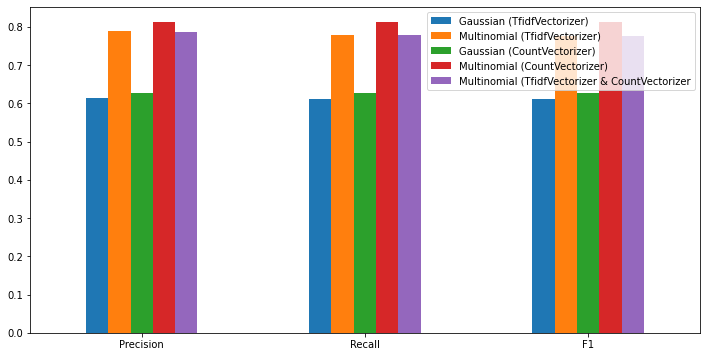

In [38]:
import pandas as pd

index_NB = ["Precision", "Recall", "F1"]

df = pd.DataFrame({"Gaussian (TfidfVectorizer)": Tfid_GNB, "Multinomial (TfidfVectorizer)": Tfid_MNB, 
                   "Gaussian (CountVectorizer)": cv_GNB, "Multinomial (CountVectorizer)": cv_MNB,
                   "Multinomial (TfidfVectorizer & CountVectorizer": pl_MNB}, index = index_NB)

ax = df.plot.bar(rot=0, figsize=(12,6))

print("====Precision, Recall and F1 Score using various models and pre-processing techniques====")
ax

**Question 4B:**

Naive Bayes classifier (NB) is a numerical supervised classification approach based on the Bayes Theorem. It is widely considered to be a computationally inexpensive, yet decisive algorithm that yields accurate results particularly in text classification. Despite being suitable on large data sets given its fast computation performance, the NB classifier is also known to work well on small training samples. NB classifier is established by the assumption that the features within a class are independent of one another. Firstly, the NB classifier computes the prior probability of a given class, before finding the probabilities of each individual feature and calculating their joint conditional probabilities through multiplication. Thereafter, these values are plugged into the bayes equation to find the posterior probabilities in order to decide which classes have the highest probabilities. Finally, the higher probability class is  assumed as the given input.


 Among various approaches to NB classifiers include, gaussian NB (GNB) based on normal distribution as well as Multinomial NB (MNB) based for frequency distribution. Overall MNB yielded the best results using a count vectorizer with F1 score of 81% outperforming the word list classifier which got an F1 score of 70.5%. In contrast to the word list classifier  which had a high precision of 78.9% and lower recall 63.6%%, MNB scored more consistently, scoring 81% for both recall and precision. Although GNB got lower F1 scores of 61%, it performed constantly for both precision and recall. This suggests that using a word list classifier with 10 words produces bias results where recall is significantly lower than precision indicating disparity in the quality of the 10 best words produced for each category.



5) 
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


**Question 5A & Experimentations**

In [39]:
# Running our program - deriving a ranked list of positive and negative words that can be used for the word list classifer 
unique_K = 1000
ratio_k = 3000
ratio = 2.5
positive_wordList, negative_wordList = get_wordList(pos_review_ids, neg_review_ids, unique_K, ratio_k, ratio)

Positive Uniques: 169
Negative Uniques169

Positive with 3000 times higher ratio: 62
Negative  with 3000 times higher ratio: 20


In [40]:
# Collecting results for different lengths of word lists 
word_list_len = [len(positive_wordList), len(negative_wordList)]

word_count = [i for i in range(0, 180, 5)]


accuracies = []
precisions = []
recalls = []
F1s = []

testing, labels = zip(*testing_norm)

# Collecting metrics with different size for word lists
for i in word_count:
  wl_classifier = WordListClassifier(positive_wordList[:i], negative_wordList[:i])
  predictions = wl_classifier.classify_many(testing)
  accuracy, precision, recall, F1 = conf_matrix(labels, predictions)
  accuracies.append(accuracy)
  precisions.append(precision)
  recalls.append(recall)
  F1s.append(F1)

In [41]:
# A function to plot performance for each score 
def plot_score_type(score_type, score_name):
  title = f"{score_name} against size of word list"
  plt.plot(word_count,score_type, label = title)
  plt.title(title)
  plt.xlabel("Size of word list")
  plt.ylabel(score_name)

  index = [idx for idx, score in enumerate(score_type) if score == max(score_type)][0]
  print(f"Peak {score_name.lower()} of {max(score_type)} is reached with word count of {word_count[index]}")

Peak accuracy of 0.84 is reached with word count of 95


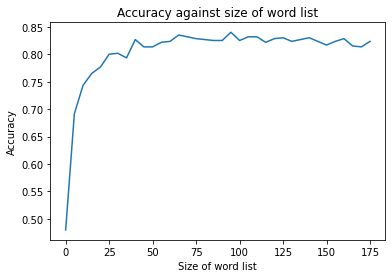

In [42]:
plot_score_type(accuracies, "Accuracy")

Peak recall of 0.8033333333333333 is reached with word count of 120


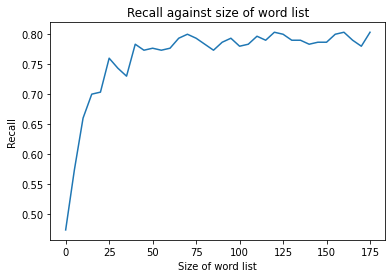

In [43]:
plot_score_type(recalls, "Recall")

Peak precision of 0.875 is reached with word count of 95


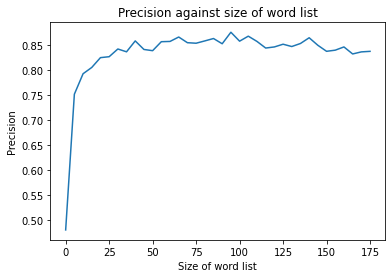

In [44]:
plot_score_type(precisions, "Precision")

Peak f1 score of 0.8321678321678322 is reached with word count of 95


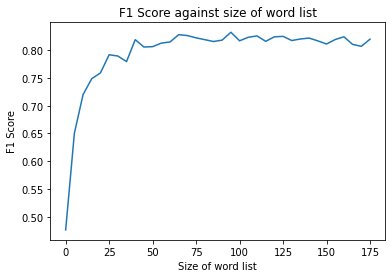

In [45]:
plot_score_type(F1s, "F1 Score")

In [46]:
# Best Word List Classifier 
import statistics

best_wl_pres = []
best_wl_rec = []
best_wl_f1 = []

best_k = 75

# Collecting results over 10 iterations
for i in range(10):
  best_wl_classifier = WordListClassifier(positive_wordList[:best_k], negative_wordList[:best_k])
  predictions = best_wl_classifier.classify_many(testing)
  _, pres, rec, f1 = conf_matrix(labels, predictions)

  best_wl_pres.append(pres)
  best_wl_rec.append(rec)
  best_wl_f1.append(f1)

best_wl_pres = statistics.mean(best_wl_pres)
best_wl_rec = statistics.mean(best_wl_rec)
best_wl_f1 = statistics.mean(best_wl_f1)

best_wl_scores = [best_wl_pres, best_wl_rec, best_wl_f1]

In [47]:
print(f"Average Precision: {best_wl_pres}")
print(f"Average Recall: {best_wl_rec}")
print(f"Average F1 Score: {best_wl_f1}")


Average Precision: 0.8605270981086361
Average Recall: 0.7956666666666666
Average F1 Score: 0.8268050533989492


In [55]:
# Classifier based on frequency score 

import time
start = time.time()

# Running our program - deriving a ranked list of positive and negative words that can be used for the word list classifer 
unique_K = 1000
ratio_k = 3000
ratio = 2.5
positive_wordList, negative_wordList = get_wordList(pos_review_ids, neg_review_ids, unique_K, ratio_k, ratio)
# Runnning classifier
freq_classifier = WordListClassifier(positive_wordList[:95], negative_wordList[:95])
freq_testing, freq_labels = zip(*testing_norm)
freq_predictions = freq_classifier.classify_many(freq_testing)
# Execution time
end = time.time()
print(f"time: {end - start}")
# Evaluating classifier  
evaluate_cls(freq_predictions)
accuracy, precision, recall, F1 = conf_matrix(freq_labels, freq_predictions)
print(f" n\Precision: {precision}")
print(f" Recall: {recall}")
print(f" F1 Score: {F1}")

Positive Uniques: 169
Negative Uniques169

Positive with 3000 times higher ratio: 62
Negative  with 3000 times higher ratio: 20
time: 32.26856303215027
===Number of Neutal Scores===

A total of 36 got neutral score and classified randomly


===Average Scores (absolute value)===

Average score: 6.078333333333333
 n\Precision: 0.8644688644688645
 Recall: 0.7866666666666666
 F1 Score: 0.8237347294938918


In [56]:
# Classifier based on frequency score 

import time
start = time.time()

# Running our program - deriving a ranked list of positive and negative words that can be used for the word list classifer 
unique_K = 1000
ratio_k = 3000
ratio = 2.5
positive_wordList, negative_wordList = get_wordList(pos_review_ids, neg_review_ids, unique_K, ratio_k, ratio)
# Runnning classifier - with all words in the word list included
freq_classifier = WordListClassifier(positive_wordList, negative_wordList)
freq_testing, freq_labels = zip(*testing_norm)
freq_predictions = freq_classifier.classify_many(freq_testing)
# Execution time
end = time.time()
print(f"time: {end - start}")

# Confusion matrix
accuracy, precision, recall, F1 = conf_matrix(freq_labels, freq_predictions)

print(f" Precision: {precision}")
print(f" Recall: {recall}")
print(f" F1 Score: {F1}")
evaluate_cls(freq_predictions)

Positive Uniques: 169
Negative Uniques169

Positive with 3000 times higher ratio: 62
Negative  with 3000 times higher ratio: 20
time: 33.73471450805664
 Precision: 0.8161290322580645
 Recall: 0.8433333333333334
 F1 Score: 0.8295081967213114
===Number of Neutal Scores===

A total of 24 got neutral score and classified randomly


===Average Scores (absolute value)===

Average score: 10.955


In [54]:
# Best Naive Bayes Classiffier
start = time.time()
best_NB_classifier = run_results(mnb, cv)
end = time.time()
print(f"time: {end - start}")

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       298
           1       0.82      0.79      0.81       302

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

time: 3.9841694831848145


Comparison of scores with the best classifier (Naive Bayes and Word List)


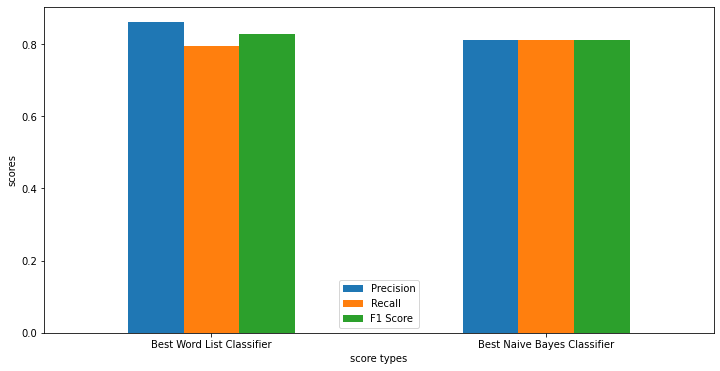

In [51]:
best_scores_listed = [[wl, nb] for wl, nb in zip(best_wl_scores, best_NB_classifier)]

index_best_ = ["Best Word List Classifier", "Best Naive Bayes Classifier"]

df = pd.DataFrame({"Precision": best_scores_listed[0], "Recall": best_scores_listed[1], 
                  "F1 Score": best_scores_listed[2]}, index = index_best_)

ax = df.plot.bar(rot=0, figsize=(12,6))
ax.set_xlabel("score types")
ax.set_ylabel("scores")
print("Comparison of scores with the best classifier (Naive Bayes and Word List)")
ax

**Question 5B:**

Having established disparities in the quality of word lists of 10 words, we aim to carry out experiments to identify a more suitable length for our word list classifier. Considering our smallest word list of filtered words is 189 words, we tested the increase in the size word from 5 to 180 words (increasing by 5 for each iteration). Our plot for F1 score against increasing size of word list suggested that the increase rate in F1 score decreases after the word list reaches a size of approximately 25 words. While precision peaked with a word list of 105 words, the overall performance appeared to be consistent with recall which peaked at 75 words. Therefore, the peak performance for F1 score was a word list of 75 words at 86%. 

Thereafter, we collected the average precision, recalls and F1 scores by running the word list classifier 10 times to minimize uncertainties posed when faced with neutral scores. This  not only presented us with a higher recall of 78.7% and higher precision of 86.5%, but we also witnessed a decrease in disparities between the two suggesting a less biased method when in comparison to a list of 10 words. Furthermore, the number of neutral scores were also reduced from 123 to only 36 from 600 predictions and the variation in scores increased from 2.17 to 6.07. Therefore, we managed to increase consistency in precision and recall by reducing the role serendipity (where neutral scores are classified randomly). Although we were able to filter an uneven number of useful words for each category (189 negatives and 231 positives), we were able to reduce the variation between precision (82.1%) and recall (85.3%) when we used all the words in both word lists derived. This suggests that our approach in filtering out useful words is rather balanced, despite producing a larger word list for the positives than negatives. This also reduced the number of neutral classification to 24 and nearly doubled the average |score| to 10.95, thus reducing bias in our classifier. 

Although the wordlist classifier produced higher precision and recall scores, MNB was more consistent with 81% for both recall and precision. This may be due to the 24 predictions that were neutral and classified randomly which may have marginally increased uncertainty in the algorithm. Considering the training data used was fairly balanced in respect to proportion and quality for both categories, we may want to consider what would happen if the data was less balanced. While the word list classifier may be altered to perform different scoring techniques such as weighing by importance or uniform score for occurrence when faced with a neutral score to reduce the role of serendipity. It would add extra complexity to our model and increase the run time. Despite the word list classifier attaining better results when fed with balanced training data, MNB may be more suitable when dealing with more biased datasets. Overall, MNB had a run time of approximately 3.9 seconds, whereas the words list classifier had run time approximately 31 seconds. Therefore, this makes MNB a better choice when dealing with larger data sets with greater uncertainties as it is 7 times faster computationally and more consistent in classification. 


In [57]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

from google.colab import drive
drive.mount('/content/drive')
import io
from nbformat import current

filepath="/content/drive/MyDrive/Colab Notebooks/NLP ASSIGNMENT FINAL.ipynb"
#filepath="NLassignment2021.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Submission length is 1812
